Downloading libraries

In [ ]:
!pip install mediapipe==0.10.13

In [1]:
!pip install -q insightface onnxruntime-gpu opencv-python scikit-learn

Setup

In [2]:
import cv2
import numpy as np
from insightface.app import FaceAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
import base64


enroll video

In [ ]:

from google.colab import files

uploaded = files.upload()

video_path = list(uploaded.keys())[0]
print("Using video:", video_path)


Uploading models

In [ ]:
# ===============================
# 🧠 Models Init
# ===============================

import cv2
import numpy as np
from insightface.app import FaceAnalysis
from sklearn.metrics.pairwise import cosine_similarity
import mediapipe as mp

# InsightFace
app = FaceAnalysis(name="buffalo_l", providers=["CPUExecutionProvider"])
app.prepare(ctx_id=0, det_size=(640,640))

# MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True
)

LEFT_EYE  = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]

def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    return (A + B) / (2.0 * C)

def detect_blink(frame, threshold=0.20):
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = face_mesh.process(rgb)
    if not result.multi_face_landmarks:
        return False

    h, w, _ = frame.shape
    lm = result.multi_face_landmarks[0].landmark

    left = np.array([(lm[i].x * w, lm[i].y * h) for i in LEFT_EYE])
    right = np.array([(lm[i].x * w, lm[i].y * h) for i in RIGHT_EYE])

    ear = (eye_aspect_ratio(left) + eye_aspect_ratio(right)) / 2
    return ear < threshold


Enrollment

In [ ]:

cap = cv2.VideoCapture(video_path)

enrolled_embedding = None
blink_confirmed = False

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    faces = app.get(frame)

    if len(faces) > 0:
        face = faces[0]

        if detect_blink(frame):
            blink_confirmed = True
            enrolled_embedding = face.embedding
            print("✅ Blink detected — Face enrolled")
            break

cap.release()

if enrolled_embedding is None:
    raise Exception("❌ Enrollment failed: no blink detected")




Testing Video

In [22]:

from google.colab import files

uploaded = files.upload()

video_path = list(uploaded.keys())[0]
print("Using video:", video_path)


Saving WIN_20251220_14_50_15_Pro.mp4 to WIN_20251220_14_50_15_Pro (2).mp4
Using video: WIN_20251220_14_50_15_Pro (2).mp4


Output Resolution Function

In [23]:
def resize_for_display(frame, max_width=700):
    h, w = frame.shape[:2]
    if w <= max_width:
        return frame

    scale = max_width / w
    new_w = int(w * scale)
    new_h = int(h * scale)
    return cv2.resize(frame, (new_w, new_h))


Testing

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


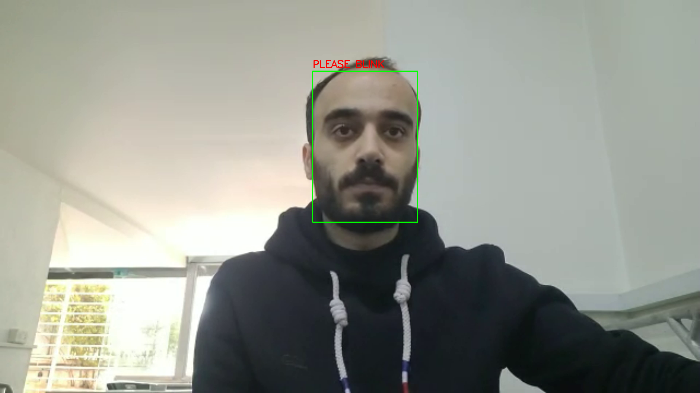

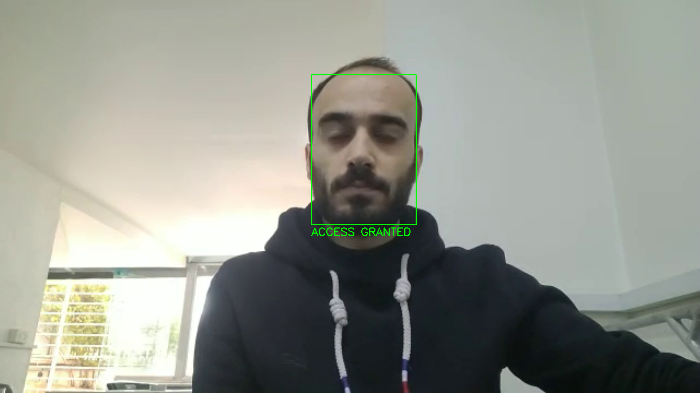

In [25]:


from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture(video_path)

verified = False
blink_detected = False
blink_frame_shown = False
result_frame_shown = False

stored_frame = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    faces = app.get(frame)
    if len(faces) == 0:
        continue

    face = faces[0]
    x1, y1, x2, y2 = face.bbox.astype(int)

    # ===============================
    # 👁️ REQUEST BLINK (once)
    # ===============================
    if not blink_detected:
        if detect_blink(frame):
            blink_detected = True
            stored_frame = frame.copy()
        else:
            if not blink_frame_shown:
                demo = frame.copy()
                cv2.rectangle(demo, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(
                    demo, "PLEASE BLINK",
                    (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (0,0,255), 2
                )
                cv2_imshow(resize_for_display(demo))
                blink_frame_shown = True
        continue

    # ===============================
    # 🔐 VERIFY (once)
    # ===============================
    similarity = cosine_similarity(
        enrolled_embedding.reshape(1,-1),
        face.embedding.reshape(1,-1)
    )[0][0]

    demo = stored_frame.copy()
    cv2.rectangle(demo, (x1, y1), (x2, y2), (0,255,0), 2)

    if similarity > 0.5:
        label = "ACCESS GRANTED"
        color = (0,255,0)
    else:
        label = "ACCESS DENIED"
        color = (0,0,255)

    cv2.putText(
        demo, label,
        (x1, y2 + 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0, color, 2
    )

    cv2_imshow(resize_for_display(demo))
    result_frame_shown = True
    break

cap.release()

if not blink_detected:
    print("❌ NO BLINK DETECTED")
